In [3]:
# SQL Engine
import sqlalchemy as sa

db_path = r"C:\Users\rober\Documents\Python\bitcoin_gold_analysis\data\bitcoin_gold_database.db"
engine = sa.create_engine(f'sqlite:///{db_path}')

inspector = sa.inspect(engine)
print(f"Tables found: {inspector.get_table_names()}")

Tables found: ['macro_data', 'market_data_filled', 'market_data_sycned']


In [4]:
column_names = [col['name'] for col in inspector.get_columns('market_data_sycned')]
column_names

['Date',
 'BTC',
 'DXY',
 'Gold',
 'SP500',
 'Yield_10Y',
 'VIX',
 'BTC_norm',
 'DXY_norm',
 'Gold_norm',
 'SP500_norm',
 'Yield_10Y_norm',
 'BTC_pct_chg',
 'DXY_pct_chg',
 'Gold_pct_chg',
 'SP500_pct_chg',
 'Yield_10Y_pct_chg']

In [5]:
import pandas as pd

# Pull Daily Market Data - Using Sycned 
df_daily = pd.read_sql(
    "SELECT Date, BTC, DXY, Gold, SP500, Yield_10Y, VIX FROM market_data_sycned", engine)

df_daily['Date'] = pd.to_datetime(df_daily['Date'])
df_daily.sort_values('Date', inplace=True)

df_daily.head()

,Date,BTC,DXY,Gold,SP500,Yield_10Y,VIX
0,2016-01-04,433.091003,98.870003,1075.099976,2012.660034,2.245,20.700001
1,2016-01-05,431.959991,99.400002,1078.400024,2016.709961,2.248,19.340000
2,2016-01-06,429.105011,99.180000,1091.900024,1990.260010,2.177,20.590000
3,2016-01-07,458.048004,98.220001,1107.699951,1943.089966,2.153,24.990000
4,2016-01-08,453.230011,98.540001,1097.800049,1922.030029,2.130,27.010000


In [6]:
# Pull Macro Data
df_macro = pd.read_sql(
    "SELECT Date, CPI_YoY, M2_YoY FROM macro_data", engine)

df_macro['Date'] = pd.to_datetime(df_macro['Date'])
df_macro.sort_values('Date', inplace=True)

df_macro.tail()

,Date,CPI_YoY,M2_YoY
115,2025-08-01,0.029392,0.044263
116,2025-09-01,0.030227,0.044897
117,2025-10-01,0.028950,0.046447
118,2025-11-01,0.027120,0.042704
119,2025-12-01,0.026533,0.046045


In [8]:
# Ensure df_daily Date is the index and datetime format
if 'Date' in df_daily.columns:
    df_daily['Date'] = pd.to_datetime(df_daily['Date'])
    df_daily.set_index('Date', inplace=True)
elif not isinstance(df_daily.index, pd.DatetimeIndex):
    df_daily.index = pd.to_datetime(df_daily.index)

# Resample Daily to Monthly (last price of each month)
monthly_market = df_daily.resample('ME').last()

# Calculate YoY % Change
market_yoy = monthly_market.pct_change(12)

# Prep Dates for df_macro
if 'Date' in df_macro.columns:
    df_macro['Date'] = pd.to_datetime(df_macro['Date'])
    df_macro.set_index('Date', inplace=True)

# Snap to Period (align 01-01 with 01-31)
if not isinstance(market_yoy.index, pd.PeriodIndex):
    market_yoy.index = market_yoy.index.to_period('M')
if not isinstance(df_macro.index, pd.PeriodIndex):
    df_macro.index = df_macro.index.to_period('M')

# Combine Market and Macro 
combined_monthly = pd.concat([
    market_yoy, 
    df_macro[['CPI_YoY', 'M2_YoY']]
], axis=1).dropna()

combined_monthly.head()

,BTC,DXY,Gold,SP500,Yield_10Y,VIX,CPI_YoY,M2_YoY
Date,,,,,,,,
2017-01,1.557232,-0.001004,0.082587,0.174530,0.269291,-0.406436,0.025104,0.063556
2017-02,1.695860,0.029630,0.015155,0.223270,0.355172,-0.371290,0.028104,0.062754
2017-03,1.571911,0.060894,0.010614,0.147096,0.341545,-0.113262,0.024412,0.063332
2017-04,1.892746,0.064138,-0.017918,0.154409,0.254535,-0.310828,0.021762,0.061129
2017-05,3.302729,0.010741,0.047086,0.150147,0.197383,-0.266385,0.018563,0.059634


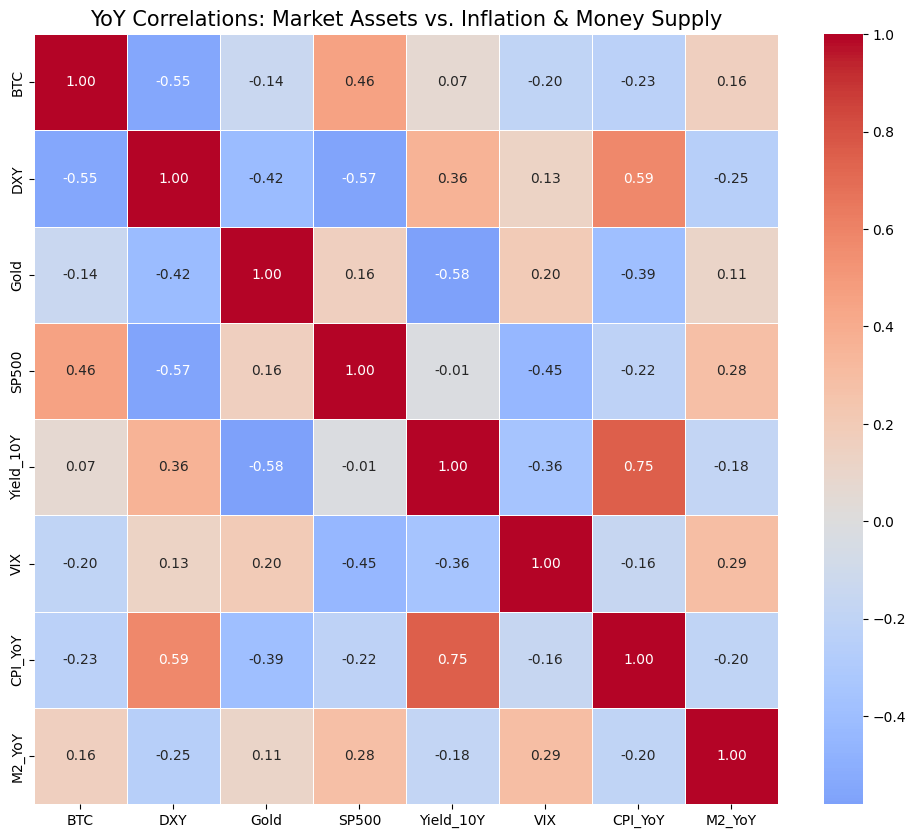

In [9]:
# Create Correlation Heatmap

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))

corr_matrix = combined_monthly.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=0.5)

plt.title('YoY Correlations: Market Assets vs. Inflation & Money Supply', fontsize=15)
plt.show()



In [11]:
# Granger Causality Test
from statsmodels.tsa.stattools import grangercausalitytests

# Testing if M2 YoY Causes BTC YoY
M2_test = combined_monthly[['BTC', 'M2_YoY']] 
gc_M2 = grangercausalitytests(M2_test, maxlag=6)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9851  , p=0.3233  , df_denom=104, df_num=1
ssr based chi2 test:   chi2=1.0135  , p=0.3141  , df=1
likelihood ratio test: chi2=1.0087  , p=0.3152  , df=1
parameter F test:         F=0.9851  , p=0.3233  , df_denom=104, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0094  , p=0.3681  , df_denom=101, df_num=2
ssr based chi2 test:   chi2=2.1188  , p=0.3467  , df=2
likelihood ratio test: chi2=2.0979  , p=0.3503  , df=2
parameter F test:         F=1.0094  , p=0.3681  , df_denom=101, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0767  , p=0.3627  , df_denom=98, df_num=3
ssr based chi2 test:   chi2=3.4607  , p=0.3259  , df=3
likelihood ratio test: chi2=3.4049  , p=0.3333  , df=3
parameter F test:         F=1.0767  , p=0.3627  , df_denom=98, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9760  , p=0.4245  , 

In [12]:
# Testing if DXY YoY Causes BTC YoY
DXY_test = combined_monthly[['DXY', 'M2_YoY']] 
gc_DXY = grangercausalitytests(DXY_test, maxlag=6)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0055  , p=0.9408  , df_denom=104, df_num=1
ssr based chi2 test:   chi2=0.0057  , p=0.9398  , df=1
likelihood ratio test: chi2=0.0057  , p=0.9398  , df=1
parameter F test:         F=0.0055  , p=0.9408  , df_denom=104, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0775  , p=0.9255  , df_denom=101, df_num=2
ssr based chi2 test:   chi2=0.1627  , p=0.9219  , df=2
likelihood ratio test: chi2=0.1626  , p=0.9219  , df=2
parameter F test:         F=0.0775  , p=0.9255  , df_denom=101, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.2064  , p=0.0265  , df_denom=98, df_num=3
ssr based chi2 test:   chi2=10.3062 , p=0.0161  , df=3
likelihood ratio test: chi2=9.8312  , p=0.0201  , df=3
parameter F test:         F=3.2064  , p=0.0265  , df_denom=98, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.4079  , p=0.0547  , 

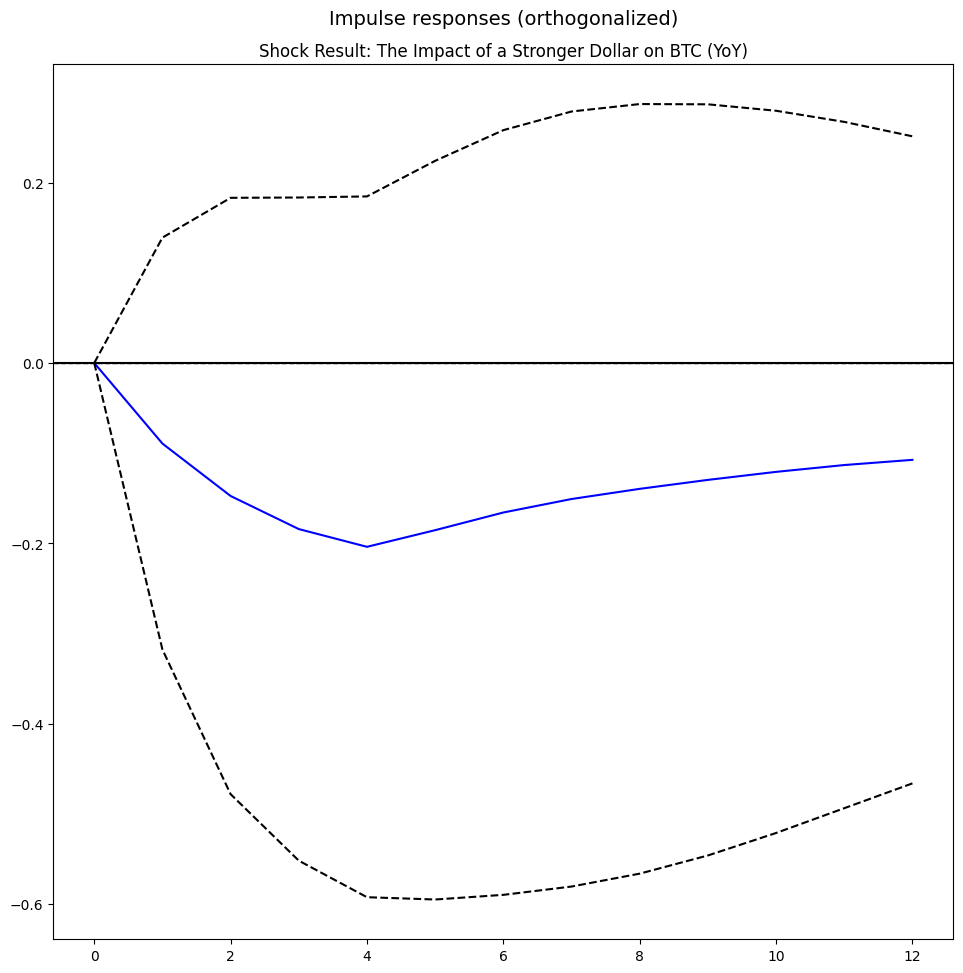

In [13]:
# Running VAR and IRP on DXY
from statsmodels.tsa.api import VAR

# Fitting VAR Model
cols = ['BTC', 'DXY', 'Gold', 'M2_YoY']
model = VAR(combined_monthly[cols])
results = model.fit(3)

# Generate IPR for 12 Months
irf = results.irf(12)

# Plotting IPR
irf.plot(impulse='DXY', response='BTC', orth=True)
plt.title("Shock Result: The Impact of a Stronger Dollar on BTC (YoY)", fontsize=12)
plt.axhline(0, color='black', lw=1, ls='--') # Add a 'zero line' for clarity
plt.show()